<a href="https://colab.research.google.com/github/KillerStrike17/EVA---Session-1-Basics-Of-DNN/blob/master/Notebook_Shubham/WideResnetResults/1_WideResNet(28_10)_Model_Augmentation_interpolated_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Choose tf2 backend on colab

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

#import tensorflow as tf
!pip install tensorflow_addons
import tensorflow_addons as tfa
import tensorflow as tf

TensorFlow 2.x selected.


### Install tf_utils

In [0]:
!pip install --upgrade git+https://github.com/ravindrabharathi/tf_utils 

  Cloning https://github.com/ravindrabharathi/tf_utils to /tmp/pip-req-build-w06egld9
  Running command git clone -q https://github.com/ravindrabharathi/tf_utils /tmp/pip-req-build-w06egld9
  Created wheel for tf-utils: filename=tf_utils-0.2-cp36-none-any.whl size=8945 sha256=89cd7b0974bd24152f16ab20e79bfd77bb290b1ae27b47cbef876ec80df65b53
  Stored in directory: /tmp/pip-ephem-wheel-cache-gy32g90s/wheels/95/af/bb/690b94c65a5aad47a5c39e75f158a2b043448e908c5c121791
Successfully built tf-utils
  Found existing installation: tf-utils 0.2
    Uninstalling tf-utils-0.2:
      Successfully uninstalled tf-utils-0.2


### import the data module

In [0]:
import tf_utils.data as ds

Finished 'get_cpu_num' in 0.0000 secs


### set batch size

In [0]:
batch_size=128
ds.batch_size=batch_size
EPOCHS=200

### downlaod data and create tf records

In [0]:
ds.get_cifar10_and_create_tfrecords()

dataset archive file exists!
Finished 'download_cifar10_files' in 0.0009 secs
./cifar10_data/cifar-10-batches-py/ is not empty and has test_batch file!
Finished 'extract_cifar10_files' in 0.0011 secs
Finished '_get_file_names' in 0.0000 secs
train.tfrecords exists!
eval.tfrecords exists!
Finished 'create_tf_records' in 0.0018 secs
Finished 'get_cifar10_and_create_tfrecords' in 0.0047 secs


### create train and test dataset

In [0]:
train_ds1=ds.get_train_ds(batch_size=batch_size,shuffle=True,distort=True)
train_ds2=ds.get_train_ds(batch_size=batch_size,shuffle=True,distort=False)

test_ds=ds.get_eval_ds(batch_size=batch_size)

distorting image
Finished 'get_tf_dataset' in 1.7325 secs
Finished 'get_tf_dataset_in_batches' in 1.7329 secs
Finished 'get_train_ds' in 1.7331 secs
Finished 'get_tf_dataset' in 0.1609 secs
Finished 'get_tf_dataset_in_batches' in 0.1612 secs
Finished 'get_train_ds' in 0.1613 secs
Finished 'get_tf_dataset' in 0.0268 secs
Finished 'get_tf_dataset_in_batches' in 0.0270 secs
Finished 'get_eval_ds' in 0.0272 secs


### import visualization module

In [0]:
import tf_utils.visualize as vz

### plot images from train dataset1 , train dataset by default uses image augmenttation of cutout,flip-left-right,random-pad-crop 

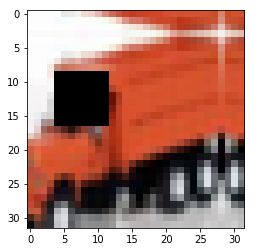

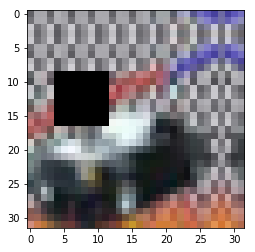

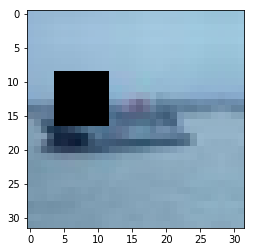

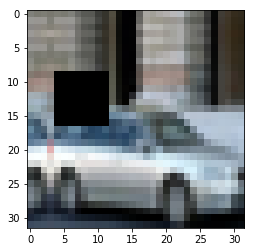

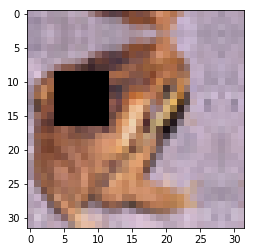

In [0]:
vz.plot_cifar10_files(train_ds1)

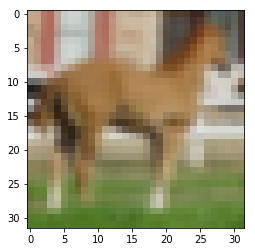

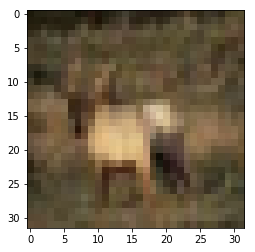

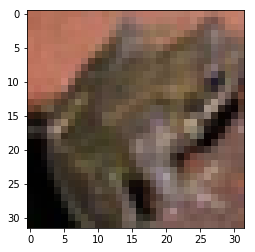

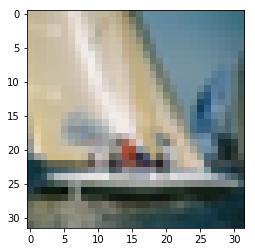

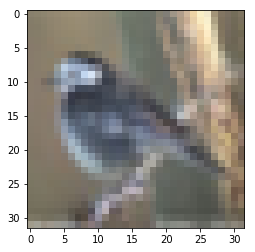

In [0]:
vz.plot_cifar10_files(train_ds2)

In [0]:
print(tf.__version__)

2.0.0


### Training - Build model , compile and train 

In [0]:
import numpy as np
import math
weight_decay=5e-4
def aug_fn1(img):
  shp=img.get_shape().as_list()
  out_shp=[shp[0],shp[1],shp[2]]
  return ds.flip_left_right(ds.random_crop(ds.cutout(ds.pad_img(img,padding=4),100,size=16),out_shape=out_shp))

def aug1(image):
  print('is_training',is_training)
  if is_training:
    
    #return tf.map_fn(lambda img: aug_fn1(img),image,parallel_iterations=ds.CPU_CORES,back_prop=is_training) 
    return tf.map_fn(lambda img: aug_fn1(img) ,image,parallel_iterations=10*ds.CPU_CORES,back_prop=is_training)    
  else:
    print('inside validation cycle\n===============\n')
    return image  


def aug_fn2(img):
  shp=img.get_shape().as_list()
  out_shp=[shp[0],shp[1],shp[2]]
  return ds.flip_left_right(ds.random_crop(ds.cutout(ds.pad_img(img,padding=4),100,size=8),out_shape=out_shp))

def aug2(image):
  print('is_training',is_training)
  if is_training:
    
    #return tf.map_fn(lambda img: aug_fn1(img),image,parallel_iterations=ds.CPU_CORES,back_prop=is_training) 
    return tf.map_fn(lambda img: aug_fn2(img) ,image,parallel_iterations=10*ds.CPU_CORES,back_prop=is_training)    
  else:
    print('inside validation cycle\n===============\n')
    return image  


def aug_fn3(img):
  shp=img.get_shape().as_list()
  out_shp=[shp[0],shp[1],shp[2]]
  return ds.flip_left_right(ds.random_crop(ds.cutout(ds.pad_img(img,padding=4),100,size=4),out_shape=out_shp))

def aug3(image):
  print('is_training',is_training)
  if is_training:
    
    #return tf.map_fn(lambda img: aug_fn1(img),image,parallel_iterations=ds.CPU_CORES,back_prop=is_training) 
    return tf.map_fn(lambda img: aug_fn3(img) ,image,parallel_iterations=10*ds.CPU_CORES,back_prop=is_training)    
  else:
    print('inside validation cycle\n===============\n')
    return image  

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
tf.keras.backend.clear_session()  
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D,  Activation, GlobalMaxPooling2D, Add
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, BatchNormalization , Dense, Lambda, AveragePooling2D, Flatten,Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import l2


In [0]:
def initial_conv(input):
    x = Convolution2D(16, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(input)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    return x

def expand_conv(init, base, k, strides=(1, 1)):
    x = Convolution2D(base * k, (3, 3), padding='same', strides=strides, kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = Convolution2D(base * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    skip = Convolution2D(base * k, (1, 1), padding='same', strides=strides, kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    m = Add()([x, skip])

    return m
def conv1_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv2_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "th" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv3_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "th" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def create_wide_residual_network(input_dim, nb_classes=100, N=2, k=1, dropout=0.0, verbose=1,model_param =0):
    """
    Creates a Wide Residual Network with specified parameters
    :param input: Input Keras object
    :param nb_classes: Number of output classes
    :param N: Depth of the network. Compute N = (n - 4) / 6.
              Example : For a depth of 16, n = 16, N = (16 - 4) / 6 = 2
              Example2: For a depth of 28, n = 28, N = (28 - 4) / 6 = 4
              Example3: For a depth of 40, n = 40, N = (40 - 4) / 6 = 6
    :param k: Width of the network.
    :param dropout: Adds dropout if value is greater than 0.0
    :param verbose: Debug info to describe created WRN
    :return:
    """
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    ip = Input(shape=input_dim)

    x = initial_conv(ip)
    nb_conv = 4

    x = expand_conv(x, 16, k)
    if model_param == 1:
      x = Lambda(aug1)(x)

    nb_conv += 2

    for i in range(N - 1):
        x = conv1_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)


    x = expand_conv(x, 32, k, strides=(2, 2))
    if model_param == 2:
      x = Lambda(aug2)(x)

    nb_conv += 2

    for i in range(N - 1):
        x = conv2_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = expand_conv(x, 64, k, strides=(2, 2))
    if model_param == 3:
      x = Lambda(aug3)(x)
    nb_conv += 2

    for i in range(N - 1):
        x = conv3_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = AveragePooling2D((8, 8))(x)
    x = Flatten()(x)

    x = Dense(nb_classes, kernel_regularizer=l2(weight_decay), activation='softmax')(x)

    model = Model(ip, x)

    if verbose: print("Wide Residual Network-%d-%d created." % (nb_conv, k))
    return model


In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model)

NameError: ignored

In [0]:

from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule():
    
    def schedule(epoch):

      lr=lr1=np.interp([epoch],[0, 60,120,160], [0.1, 0.02, 0.004,0.0008])[0]
      print('epoch ', epoch+1, ': setting learning rate to ',lr1)
      return lr
    
    return LearningRateScheduler(schedule)

lr_sched = lr_schedule()

In [0]:
for i in [0]:
  init = (32, 32, 3)
  is_training = True
  model = create_wide_residual_network(init, nb_classes=10, N=4, k=10, dropout=0.3,model_param = i)

  model.summary()


  opt=SGD(lr=0.1,momentum=0.9,nesterov=True)
  model.compile(loss='categorical_crossentropy',
            optimizer=opt,metrics=['accuracy']
            )
  train_ds=train_ds2  
  model.fit(train_ds,epochs=EPOCHS, steps_per_epoch=np.ceil(50000/batch_size), 
          callbacks=[lr_sched],
          verbose=1,validation_data = test_ds, validation_steps = np.ceil(10000/batch_size))
  #score=model.evaluate(test_ds, steps =np.ceil(10000/batch_size), verbose=1)


  #print('val accuracy score at the end of training model type ', score)
  print("=========================================\n")

  #validation_data=test_ds, validation_steps=np.ceil(10000/batch_size),

Wide Residual Network-28-10 created.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
_________________________________________________________